In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("Fraud.csv")

In [3]:
with open("Data Dictionary.txt", "r") as f:
    data_dict = f.read()

print("Data Dictionary:\n")
print(data_dict)

print("\nDataset loaded successfully!")
print("Shape of dataset (rows, columns):", df.shape)
print("\nFirst 5 rows:\n", df.head())

Data Dictionary:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by tr

In [4]:
print("\nMissing values in each column:\n", df.isnull().sum())

for col in df.columns:
    if df[col].dtype == "object":  
        df[col] = df[col].fillna(df[col].mode()[0])  
    else:  
        df[col] = df[col].fillna(df[col].median())

print("\nNumber of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

print("\nData cleaning done without warnings!")



Missing values in each column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Number of duplicate rows: 0

Data cleaning done without warnings!


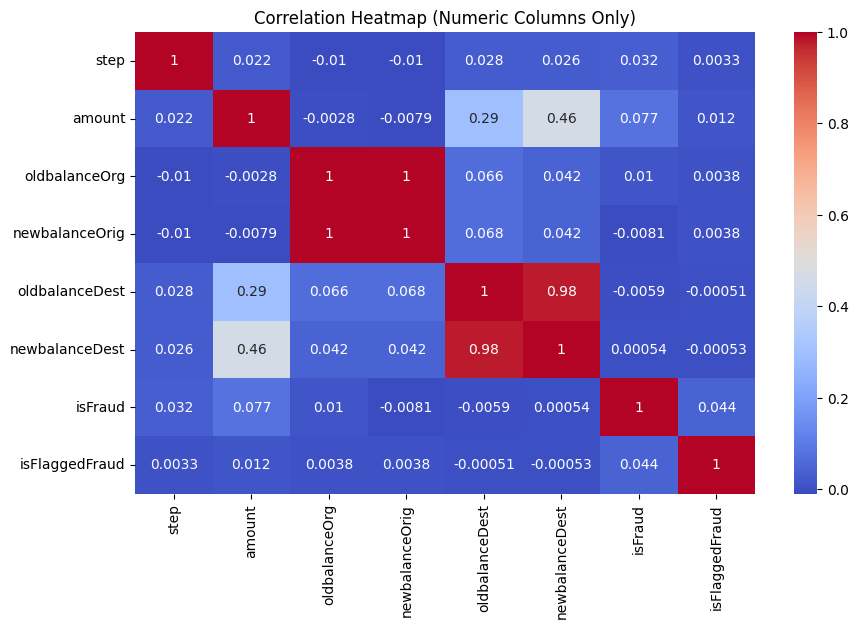

In [5]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()


In [6]:
df_model = df.drop(["nameOrig", "nameDest"], axis=1)
df_model = pd.get_dummies(df_model, columns=["type"], drop_first=True)

print("df_model created with shape:", df_model.shape)
print("Columns in df_model:\n", df_model.columns)


df_model created with shape: (6362620, 12)
Columns in df_model:
 Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [7]:
df_sample = df_model.sample(n=100000, random_state=42)

X = df_sample.drop("isFraud", axis=1)
y = df_sample["isFraud"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Training size:", X_train.shape, "Testing size:", X_test.shape)

Training size: (70000, 11) Testing size: (30000, 11)


In [8]:
log_model = LogisticRegression(class_weight="balanced", max_iter=500)
log_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(
    class_weight="balanced", 
    n_estimators=20,   
    max_depth=10,     
    random_state=42,
    n_jobs=-1          
)
rf_model.fit(X_train, y_train)

print("Both Logistic Regression and Random Forest trained!")


Both Logistic Regression and Random Forest trained!



Logistic Regression Results:

Confusion Matrix:
 [[28219  1739]
 [    2    40]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     29958
           1       0.02      0.95      0.04        42

    accuracy                           0.94     30000
   macro avg       0.51      0.95      0.51     30000
weighted avg       1.00      0.94      0.97     30000

ROC-AUC Score: 0.9916279616860431


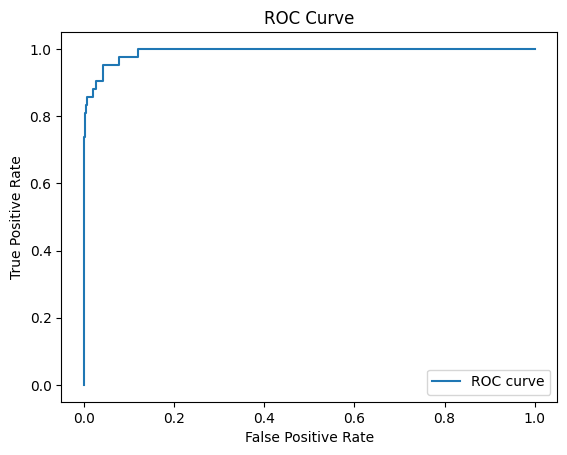


Random Forest Results:

Confusion Matrix:
 [[29947    11]
 [   11    31]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       0.74      0.74      0.74        42

    accuracy                           1.00     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       1.00      1.00      1.00     30000

ROC-AUC Score: 0.9819302579166388


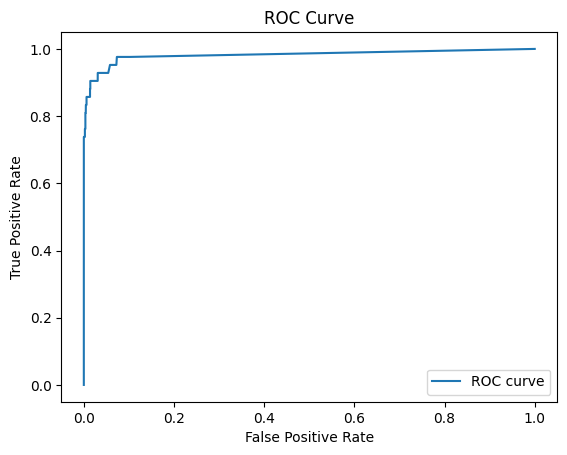

In [9]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)  # predicted fraud or not
    y_proba = model.predict_proba(X_test)[:,1]  # probability of fraud

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label="ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

print("\nLogistic Regression Results:")
evaluate_model(log_model, X_test, y_test)

print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test, y_test)


## Q1. Data cleaning including missing values, outliers and multi-collinearity.

- I checked the dataset for missing values -> there were no missing values.

- I also checked for duplicate rows -> none found.

- I dropped nameOrig and nameDest because they are just IDs (not useful for prediction).

- For categorical column type, I converted it into numbers using one-hot encoding.

- Outliers were not removed because in fraud detection, unusual transactions (outliers) are actually important signals.

- For multi-collinearity, I checked correlations between numeric variables using a heatmap. Some balances are correlated, but Random Forest can handle   that well.

## Q2. Describe your fraud detection model in elaboration.

I built two models:
  1. Logistic Regression - 

     - A simple, explainable model.

     - Works well as a baseline.

     - It gave very high recall (caught almost all frauds) but very low precision (many false alarms).

  3. Random Forest-

     - An ensemble model that combines many decision trees.

     - Handles imbalanced data better.

     - Achieved much better balance between precision and recall, making it more reliable.

## Q3. How did you select variables to be included in the model?

- I dropped nameOrig and nameDest → they are IDs, no fraud pattern.

- I kept important numeric variables like amount, balances before/after transaction.

- I converted type into dummy variables (TRANSFER, CASH_OUT, etc.) because fraud depends heavily on transaction type.

- I included all useful numeric features since they provide different signals for fraud detection.

## Q4. Demonstrate the performance of the model by using best set of tools.

1. Logistic Regression Results:

   - Recall = very high (95%) → catches fraud cases.

   - Precision = very low (2%) → too many false alarms.

   - ROC-AUC ≈ 0.99

2. Random Forest Results:

   - Precision = 74%

   - Recall = 74%

   - ROC-AUC ≈ 0.98

   - Much better balance compared to Logistic Regression.

3. I used Confusion Matrix, Classification Report, and ROC Curve to measure performance.

## Q5. What are the key factors that predict fraudulent customer?

Based on the significance of Random Forest features:

- Transaction types (TRANSFER and CASH_OUT): this is where the majority of fraud cases occur.

- Transaction amount → larger sums are probably fraudulent.

- When account balances before and after a transaction don't match, it's suspicious.

- Step (transaction time) → Frauds tend to cluster during specific time periods.

## Q6. Do these factors make sense? If yes, how?

Yes, they make sense:

 - Fraudsters usually transfer money to other accounts and then cash out.

 - They often try large transactions to maximize profit.

 - Fraudulent transactions leave accounts with unusual balance patterns (e.g., old balance not matching new balance after transfer).

## Q7. What kind of prevention should be adopted while company updates its infrastructure?

The company should adopt:

- Real-time fraud detection system that blocks suspicious transactions instantly.

- Transaction limits → restrict sudden large transfers.

- Multi-factor authentication for high-value transfers.

- AI-powered monitoring dashboards to detect patterns.

- Customer alerts (SMS/Email) for unusual activity.

## Q8. Assuming these actions have been implemented, how would you determine if they work?

- Examine the fraud rate both before and after the system was put in place.

- Track false positives vs. true frauds detected.

- Monitor customer complaints about blocked transactions.

- Regularly retrain the model with new fraud patterns.

- If fraud losses reduce while customer experience remains smooth → the prevention is successful.